In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt 
import tensorflow as tf

from src.layers.attention import scaled_dot_product_attention

%load_ext autoreload
%autoreload 2

2024-01-31 20:45:29.046856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
num_head = 4
window_size = 100
head_dim = 32

Q = tf.random.normal([1, num_head, window_size, head_dim])
K = tf.random.normal([1, num_head, window_size, head_dim])
V = tf.random.normal([1, num_head, window_size, head_dim])

mask = tf.concat([tf.ones(50), tf.zeros(50)], 0)
mask = tf.reshape(mask, [1, -1, 1])

2024-01-31 20:45:30.648879: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: UNKNOWN ERROR (34)
2024-01-31 20:45:30.648916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fb9e7979b2f1): /proc/driver/nvidia/version does not exist
2024-01-31 20:45:30.649155: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
-1e9

-1000000000.0

In [17]:
alphas = [-1e9, -0.5, 0, 0.5, 1, 1.5]
labels = [r'$\alpha=-\inf$', r'$\alpha=-0.5$', r'$\alpha=0$', r'$\alpha=0.5$', 
          r'$\alpha=1.$', r'$\alpha=1.5$']

tf.Tensor(0.99999994, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.99999994, shape=(), dtype=float32)
tf.Tensor(0.99999994, shape=(), dtype=float32)
tf.Tensor(1.0000001, shape=(), dtype=float32)
tf.Tensor(1.0000001, shape=(), dtype=float32)


Text(0.5, 1.1, '$\\rm{W} = e^{QK + \\alpha M} \\frac{1}{\\sum e^{QK+ \\alpha M}}$')

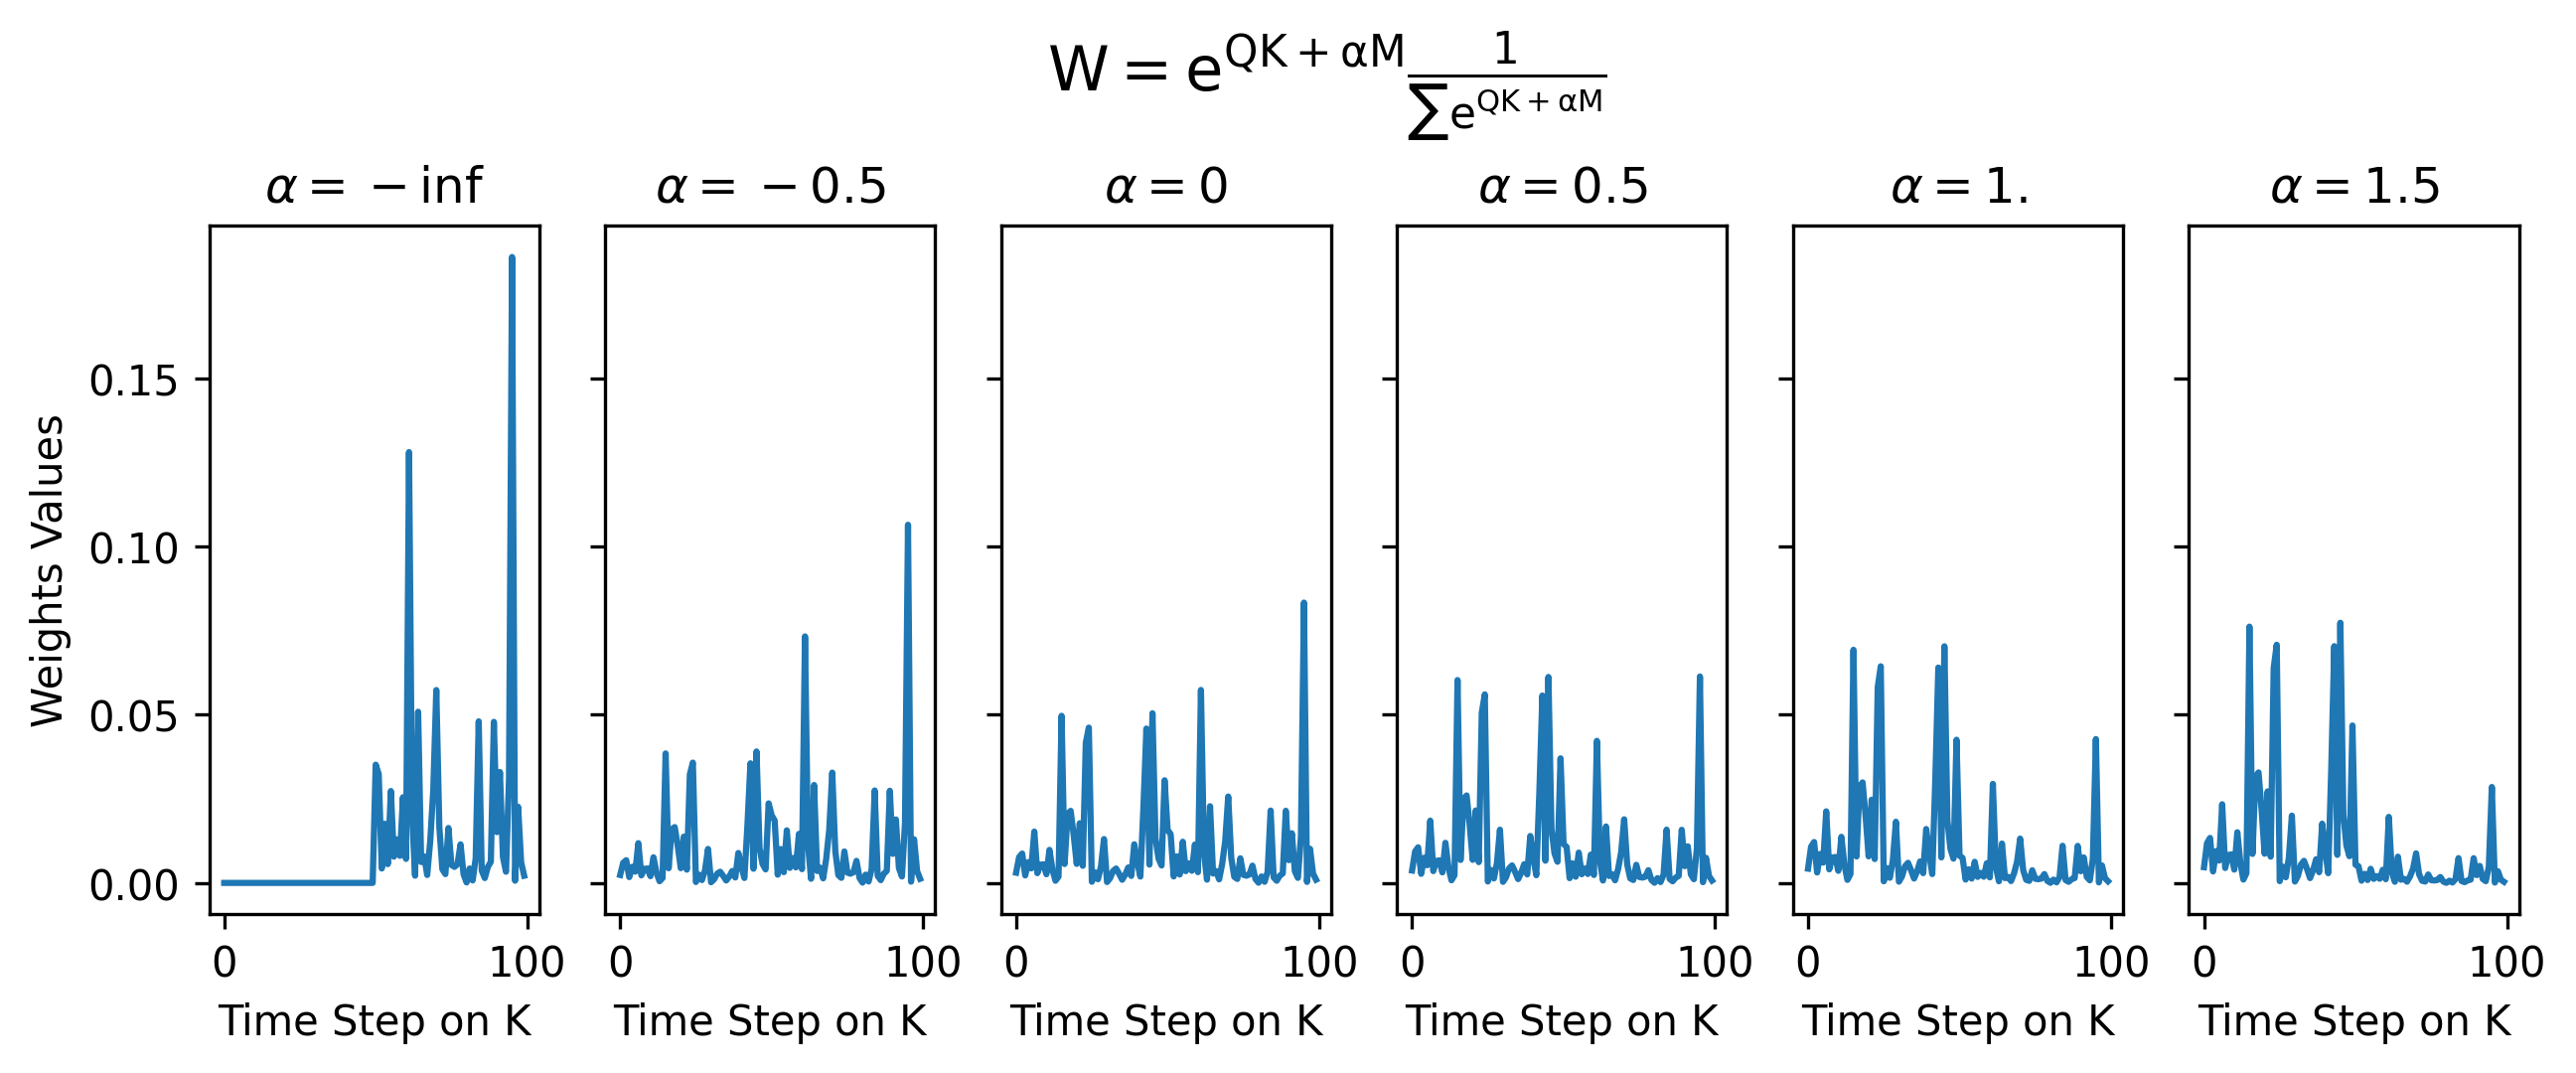

In [18]:
fig, axes = plt.subplots(1, 6, figsize=(10, 3), dpi=300, sharey=True)
axes = axes.flatten()
sim_matrices = []
for i, alp in enumerate(alphas):

    scaled_attention, \
    attention_weights = scaled_dot_product_attention(Q, K, V, mask=mask, alpha=alp)


    v = attention_weights[0, 0, 50]
    print(tf.reduce_sum(v)) 

    axes[i].plot(v)
    axes[i].set_title('{}'.format(labels[i]))
    
    axes[i].set_xlabel('Time Step on K')
    sim_matrices.append(attention_weights[0, 0])
    
axes[0].set_ylabel('Weights Values')
fig.text(0.5,1.1,r'$\rm{W} = e^{QK + \alpha M} \frac{1}{\sum e^{QK+ \alpha M}}$',horizontalalignment='center',
       verticalalignment='top', fontsize=15)

Text(0, 0.5, 'Time Step on Q')

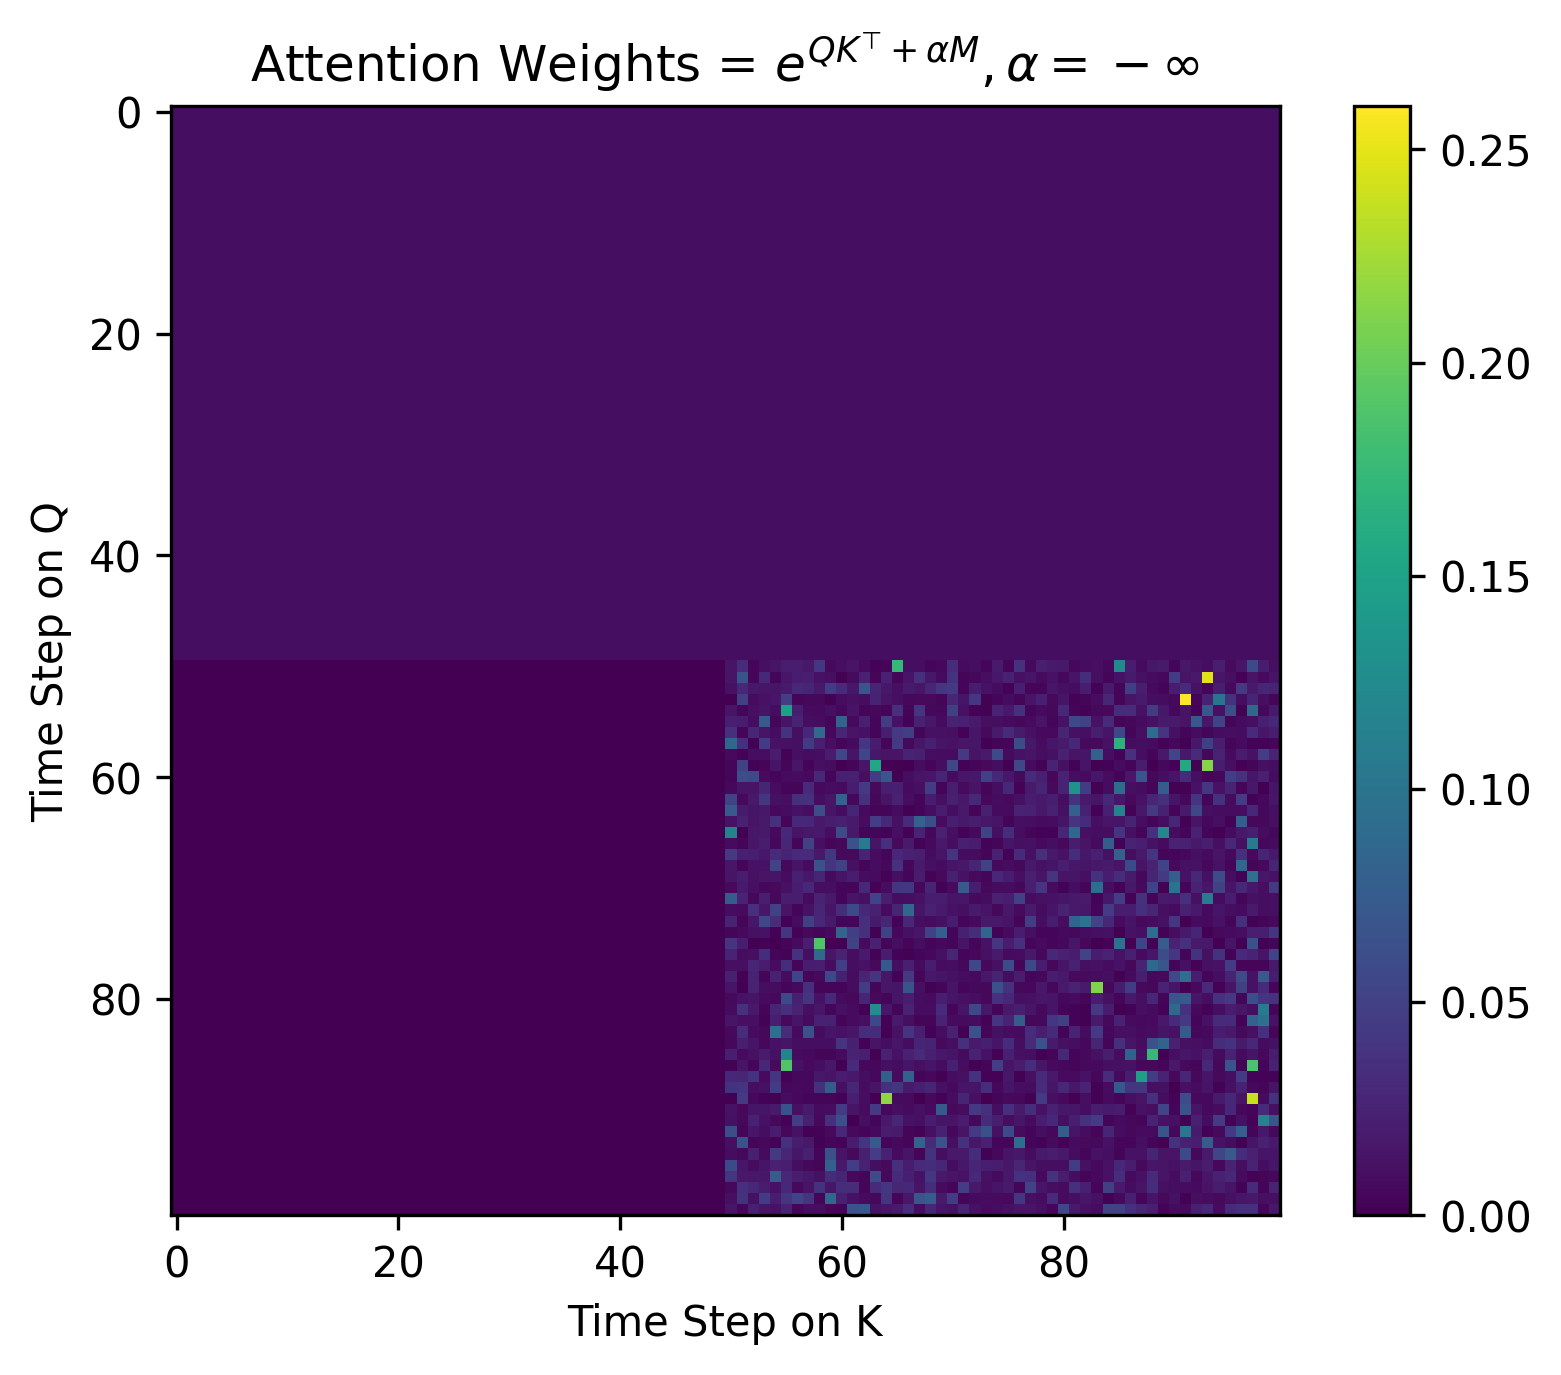

In [139]:
plt.figure(dpi=300)
plt.imshow(sim_matrices[0])
plt.title(r'Attention Weights = $e^{QK^{\top} + \alpha M}, \alpha = -\infty$')
plt.colorbar()
plt.xlabel('Time Step on K')
plt.ylabel('Time Step on Q')

In [23]:
attention_weights[0, 0, 1] + attention_weights[0, 0, 0, 0] 

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02], dtype=float32)>

Text(0, 0.5, '$e^{QK + M\\alpha}$')

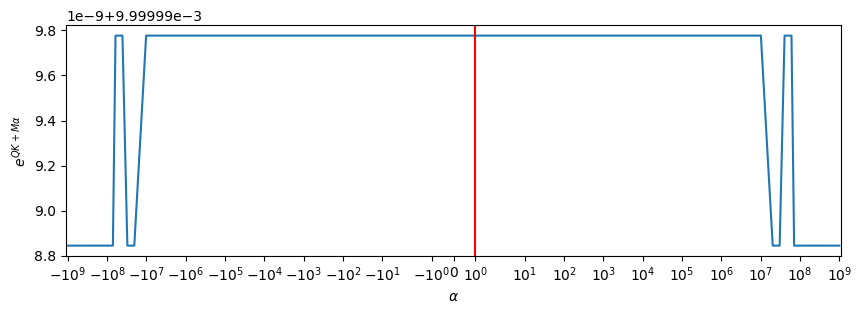

In [10]:
plt.figure(figsize=(10,3))
plt.plot(alphas, ratios)
plt.axvline(x=1, color='red', label='Bugstromer')
plt.xscale('symlog')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$e^{QK + M\alpha}$')

In [11]:
tf.reduce_max(ratios)

<tf.Tensor: shape=(), dtype=float32, numpy=0.01>